<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/carry/Perp_Funding_Carry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perp Funding Effects - Initial Exploratory Analysis

* Does funding rate predict future funding returns?
* Does funding rate predict future price moves?


In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'roll'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpD8lcwZ/remotes7454d5dc96/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’



# What data do we want?

* Perp prices
* Perp funding rates

In [2]:
rwlab_data_auth()

Authorization successful!

In [3]:
# snippet: rw crypto load ftx futures v0.1
futures <- rwRtools::crypto_get_futures()

futures %>% 
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

# snippet: rw crypto load ftx perpetual funding rates v0.1
perp_rate <- rwRtools::crypto_get_perp_rates()

perp_rate %>%
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 232.4…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-07-20 12:00:00,2022-11-12


ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rates.…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-03-06 15:00:00,2022-11-12


# Prepare Data for Analysis

Calculate returns

* Positive rate = longs pay shorts
* Negative rate = shorts pay longs

We convert all rates to be the returns to longs.

In [4]:
perp_rate %>% head()

ticker,date,rate
<chr>,<dttm>,<dbl>
1INCH-PERP,2020-12-25 03:00:00,0.000000
1INCH-PERP,2020-12-25 04:00:00,0.000000
1INCH-PERP,2020-12-25 05:00:00,0.000000
1INCH-PERP,2020-12-25 06:00:00,0.000558
1INCH-PERP,2020-12-25 07:00:00,0.000120
1INCH-PERP,2020-12-25 08:00:00,0.000123


In [5]:
funding_data <- futures %>% 
  inner_join(perp_rate, by = c('ticker','date')) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    price_change = log(close / lag(close)),
    funding_accrual = -lead(rate)
  ) %>% 
  na.omit()

How "sticky" is the funding rate?

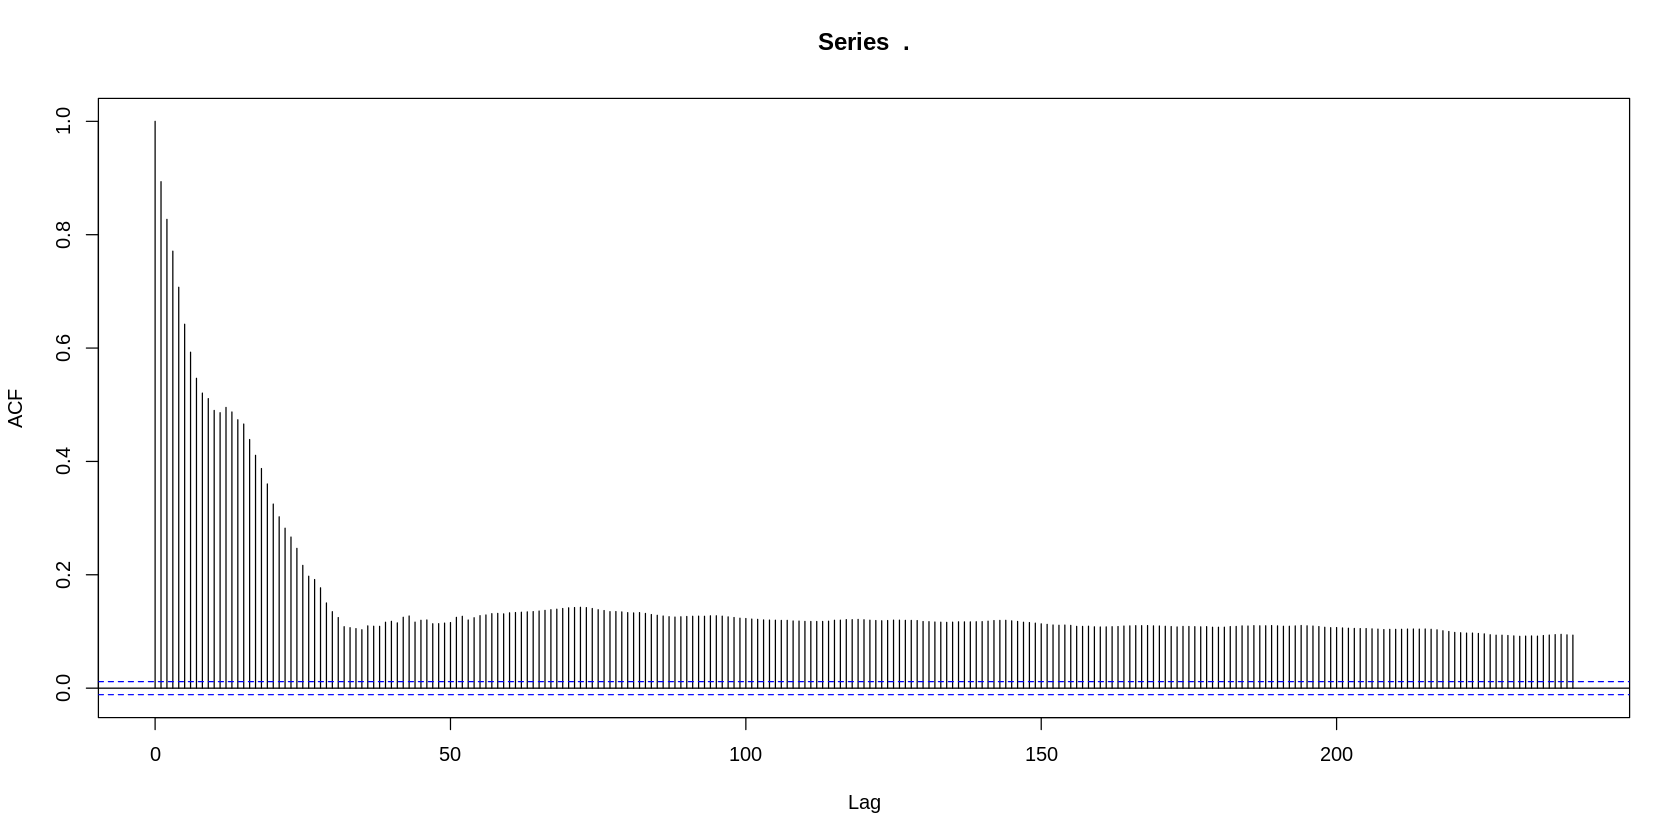

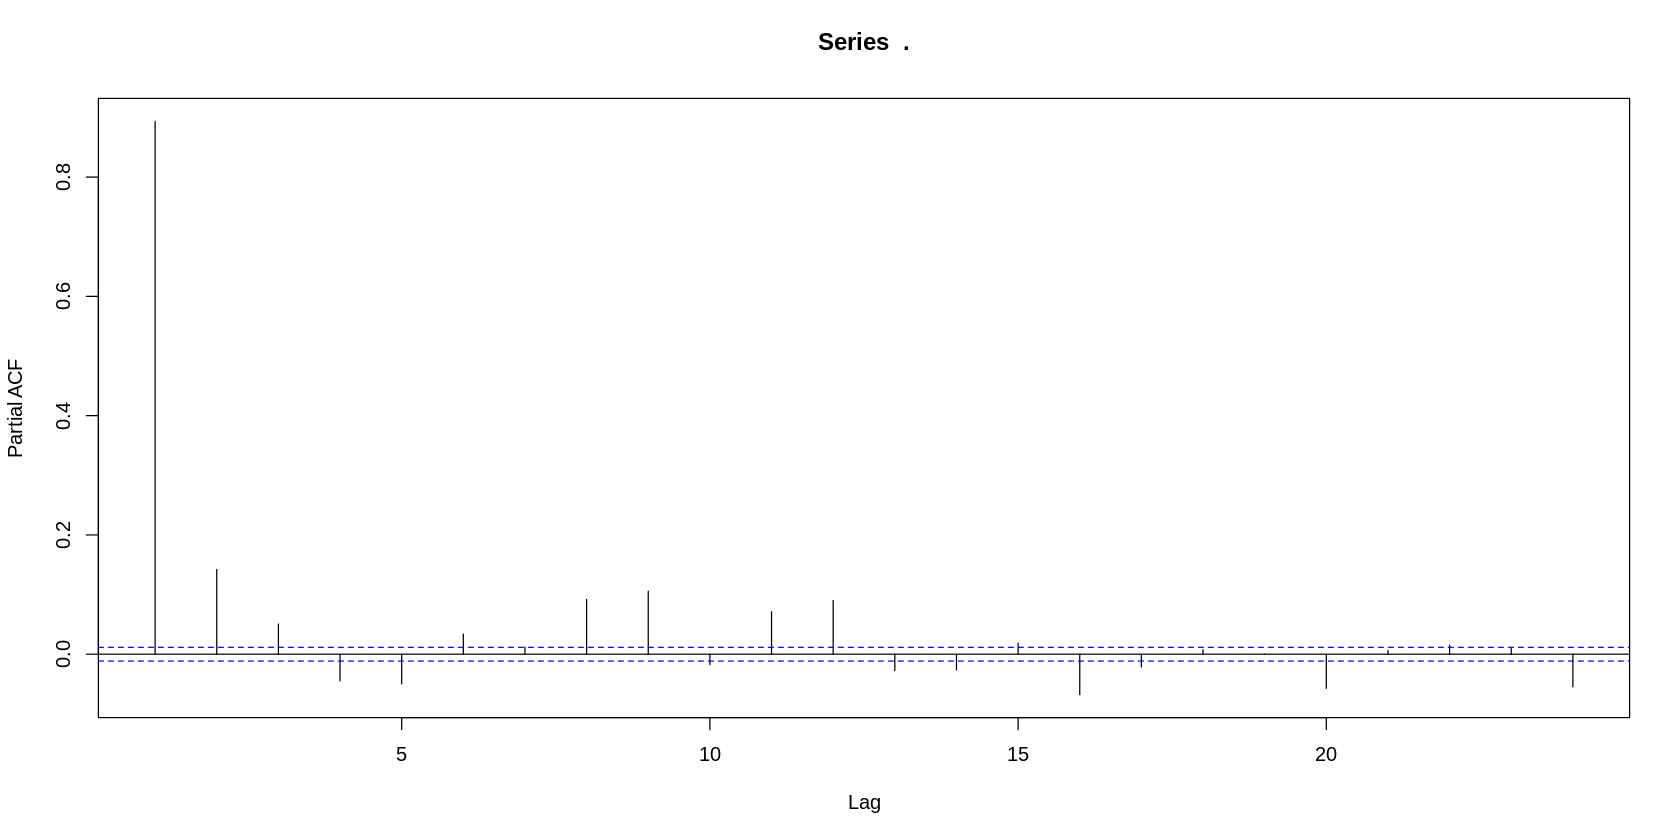

In [6]:
the_ticker <- 'BTC-PERP'

# autocorrelation
funding_data %>%
  filter(ticker == the_ticker) %>%
  pull(funding_accrual) %>%
  acf(lag.max = 240)

# partial autocorrelation
funding_data %>%
  filter(ticker == the_ticker) %>%
  pull(funding_accrual) %>%
  pacf(lag.max = 24)

Look at changes in funding rate

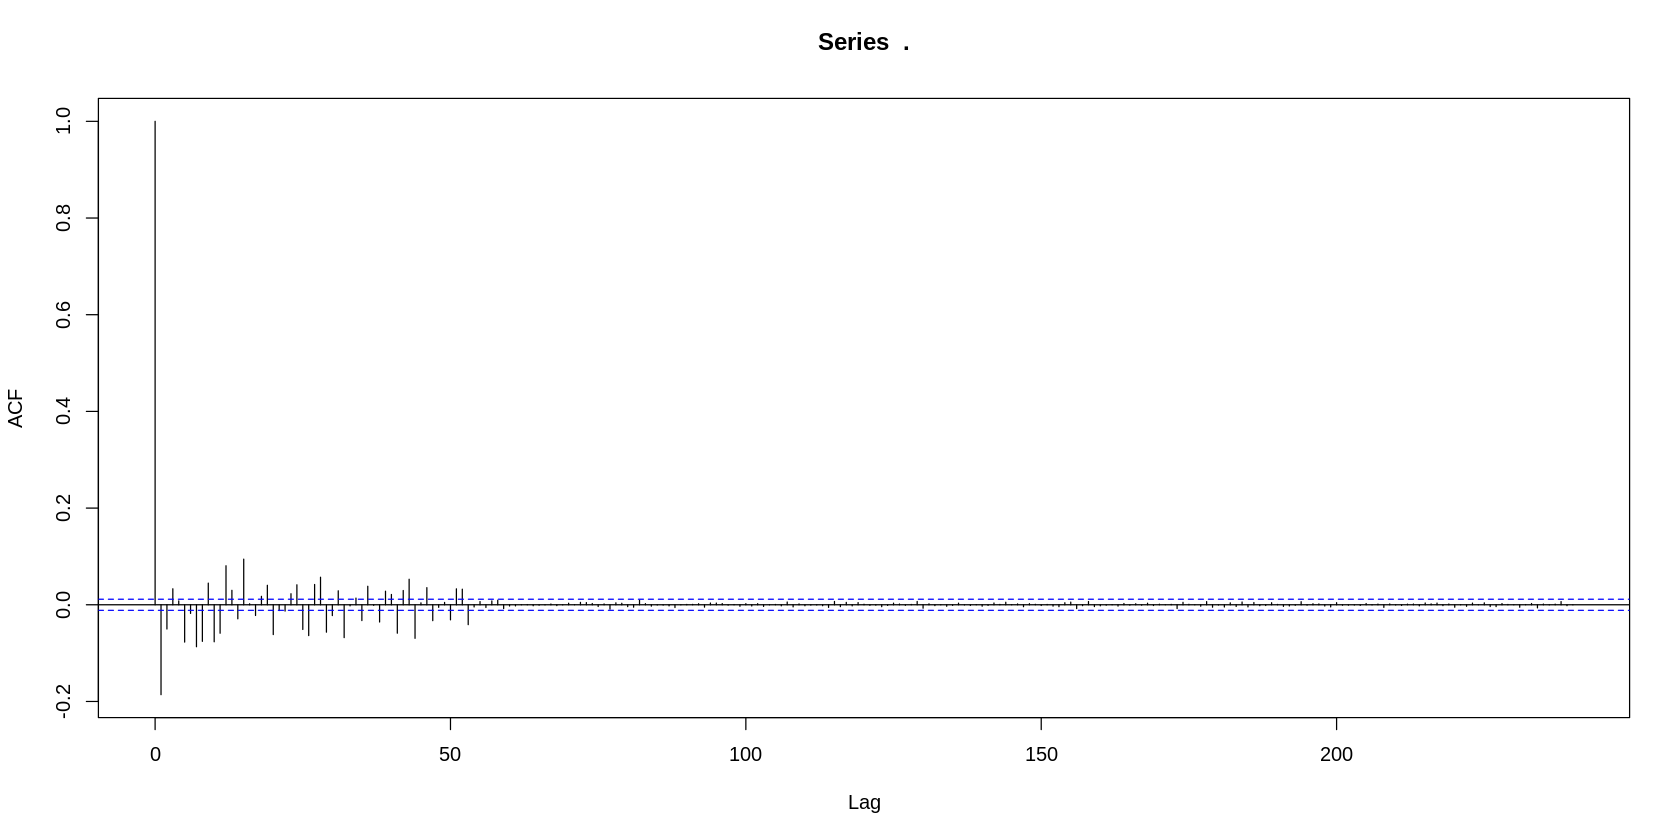

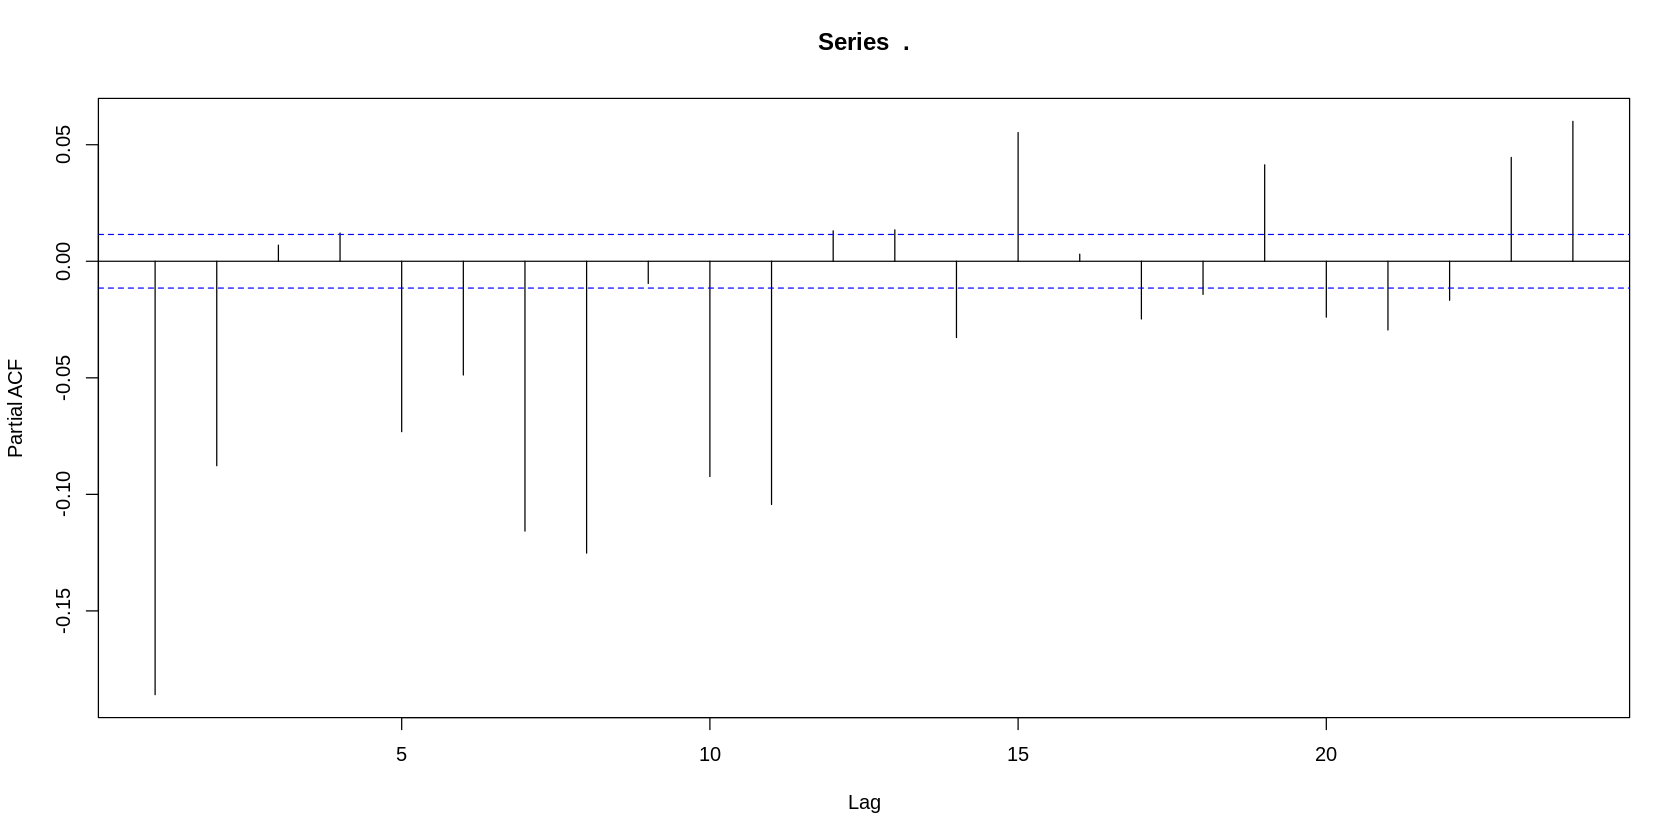

In [7]:
the_ticker <- 'BTC-PERP'

# autocorrelation
funding_data %>%
  filter(ticker == the_ticker) %>%
  pull(funding_accrual) %>%
  diff() %>%
  acf(lag.max = 240)

# partial autocorrelation
funding_data %>%
  filter(ticker == the_ticker) %>%
  pull(funding_accrual) %>%
  diff() %>%
  pacf(lag.max = 24)

Clear reversion towards the mean, esp hourly.

# Carry as predictor of total returns

To make analysis easier, let's downsample to daily observations.

In [8]:
daily_funding <- funding_data %>%
  mutate(date = as_date(date)) %>%
  group_by(ticker, date) %>%
  summarize(
    volume = sum(volume),
    price_change = sum(price_change),
    funding_accrual = sum(log(funding_accrual + 1)),
  ) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(lag_funding_accrual = lag(funding_accrual)) %>%
  na.omit()

daily_funding %>% head()

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,date,volume,price_change,funding_accrual,lag_funding_accrual
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
ALGO-PERP,2019-07-21,159066.40,-0.021104448,-4.950140e-04,-4.700141e-05
ALT-PERP,2019-07-21,197649.87,-0.007201677,-4.770134e-04,1.999946e-04
BCH-PERP,2019-07-21,41817.78,-0.012713350,9.959737e-04,5.299804e-04
BNB-PERP,2019-07-21,226812.72,-0.024189491,-4.930141e-04,-3.360068e-04
BSV-PERP,2019-07-21,222996.06,0.018024672,-5.901206e-05,-1.980034e-04
BTC-PERP,2019-07-21,74002919.33,-0.016577682,1.559984e-04,-1.300012e-04


Let's sort cross-sectionally

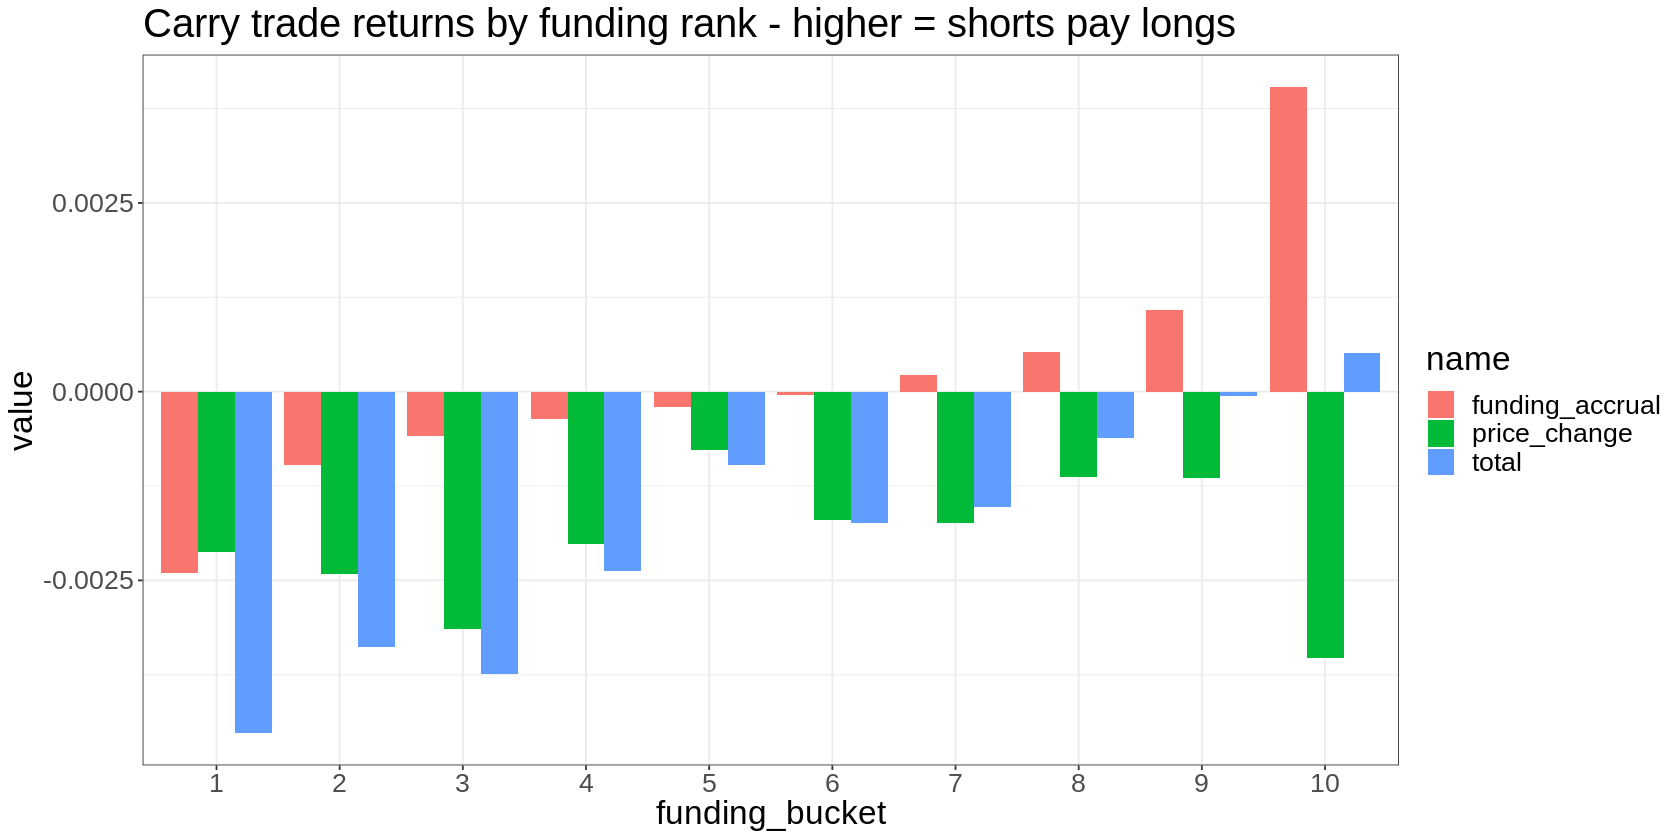

In [9]:
daily_funding %>%
  group_by(date) %>%
  mutate(funding_bucket = factor(ntile(lag_funding_accrual, 10))) %>%
  group_by(funding_bucket) %>%
  summarize(
    price_change = mean(price_change),
    funding_accrual = mean(funding_accrual),
    total = price_change + funding_accrual
  ) %>%
  pivot_longer(-funding_bucket) %>%
  ggplot(aes(x=funding_bucket, y=value, fill=name)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('Carry trade returns by funding rank - higher = shorts pay longs')

Let's do a little simulation of:
 - longing the top 5
 - shorting the bottom 5

In [10]:
daily_returns <- daily_funding %>%
  group_by(date) %>%
  mutate(
    short_funding_rank = row_number(lag_funding_accrual),
    long_funding_rank = row_number(-lag_funding_accrual),
    position = case_when(short_funding_rank <= 5 ~ "Short", long_funding_rank <= 5 ~ "Long")
  ) %>%
  ungroup() %>%
  group_by(date, position) %>%
  summarize(
    price_change = mean(price_change),
    funding_accrual = mean(funding_accrual)
  )

daily_returns %>% head()

`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


date,position,price_change,funding_accrual
<date>,<chr>,<dbl>,<dbl>
2019-07-21,Long,-0.0050772781,-1.613275e-06
2019-07-21,Short,-0.0004386819,-1.048867e-03
2019-07-21,NA,-0.0149201755,-1.477560e-04
2019-07-22,Long,-0.0310734887,-1.010121e-04
2019-07-22,Short,-0.0384496586,-1.556306e-03
2019-07-22,NA,-0.0341601723,-2.862581e-04


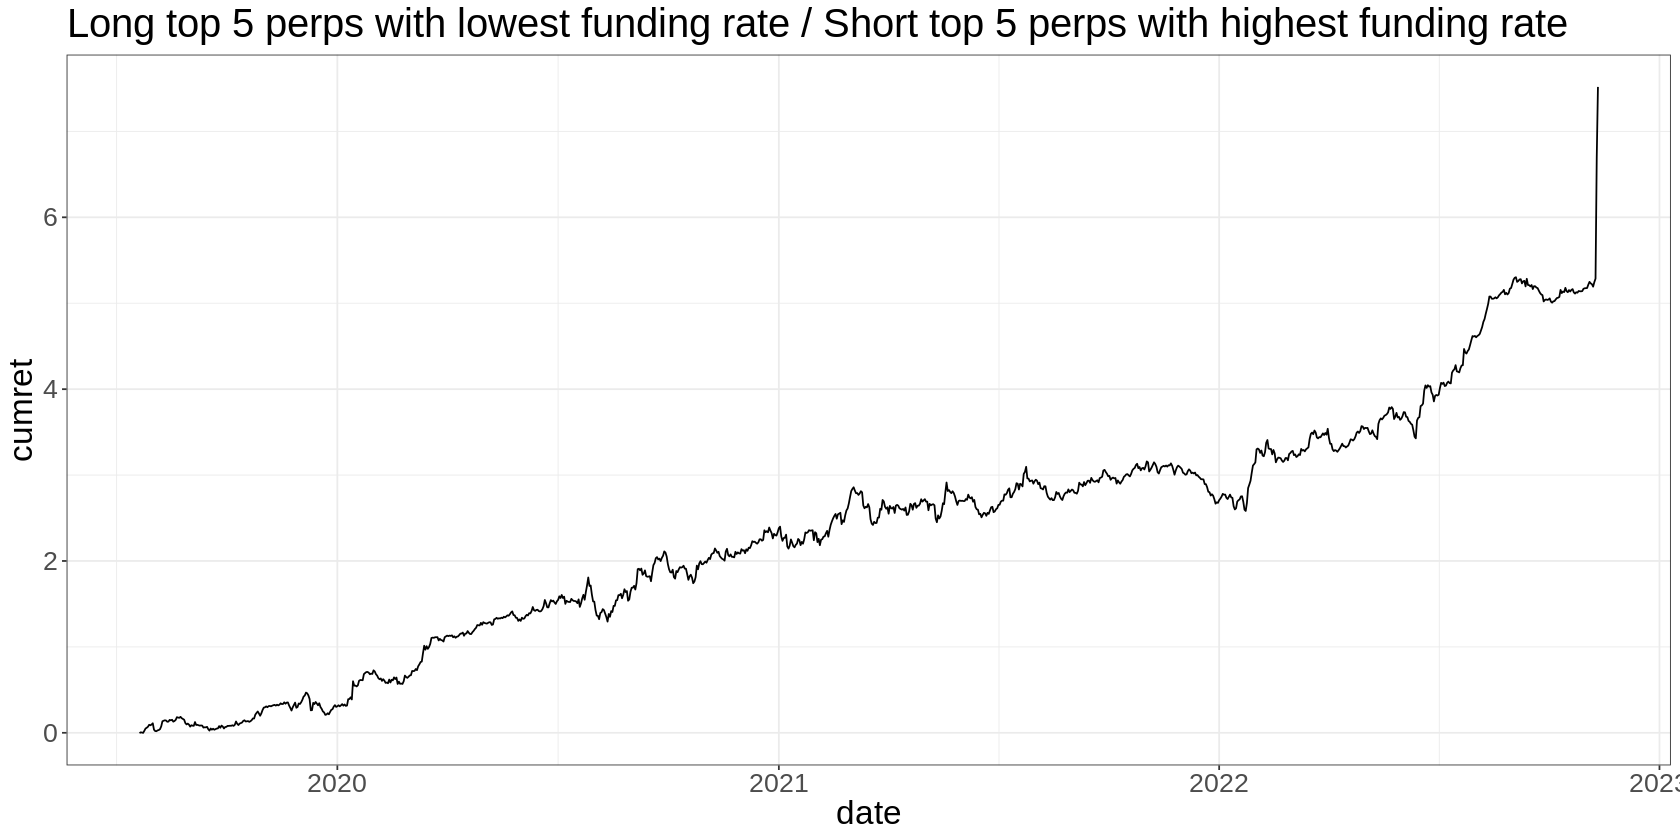

In [11]:
daily_returns %>% 
  filter(!is.na(position)) %>%
  mutate(
    total_returns = case_when(position == 'Long' ~ price_change + funding_accrual, position == 'Short' ~ -(price_change + funding_accrual))
  ) %>%
  group_by(date) %>%
  summarize(total_returns = sum(total_returns)) %>%
  arrange(date) %>%
  mutate(cumret = cumsum(total_returns)) %>%
  ggplot(aes(x=date, y=cumret)) + geom_line() + 
    ggtitle('Long top 5 perps with lowest funding rate / Short top 5 perps with highest funding rate')

Of course, we have a lot of trash liquidity here... but this is usefully indicative. 

Shall we be more careful about our analysis?

Let's introduce some new concepts... 

# The Information Coefficient

The information coefficient is the correlation of ex-ante signal forecasts with future realized returns.

Let's calculate the information coefficient of our carry signal to explain total returns.

It's useful to work with because it's a single number we can compare across a lot of things. It's useful if our ultimate goal is to create a multi-feature stat arb meta model.

In [12]:
daily_funding %>% head()

ticker,date,volume,price_change,funding_accrual,lag_funding_accrual
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
ALGO-PERP,2019-07-21,159066.40,-0.021104448,-4.950140e-04,-4.700141e-05
ALT-PERP,2019-07-21,197649.87,-0.007201677,-4.770134e-04,1.999946e-04
BCH-PERP,2019-07-21,41817.78,-0.012713350,9.959737e-04,5.299804e-04
BNB-PERP,2019-07-21,226812.72,-0.024189491,-4.930141e-04,-3.360068e-04
BSV-PERP,2019-07-21,222996.06,0.018024672,-5.901206e-05,-1.980034e-04
BTC-PERP,2019-07-21,74002919.33,-0.016577682,1.559984e-04,-1.300012e-04


Let's just take the raw funding rate as a feature, for now.

In [13]:
daily_funding %>%
  ungroup() %>%
  summarise(IC = cor(lag_funding_accrual, price_change + funding_accrual))

IC
<dbl>
0.08420342


We can explain about 2% of the variance in perp returns by the carry feature.

Now let's observe how the information coefficient decays as we look outwards.

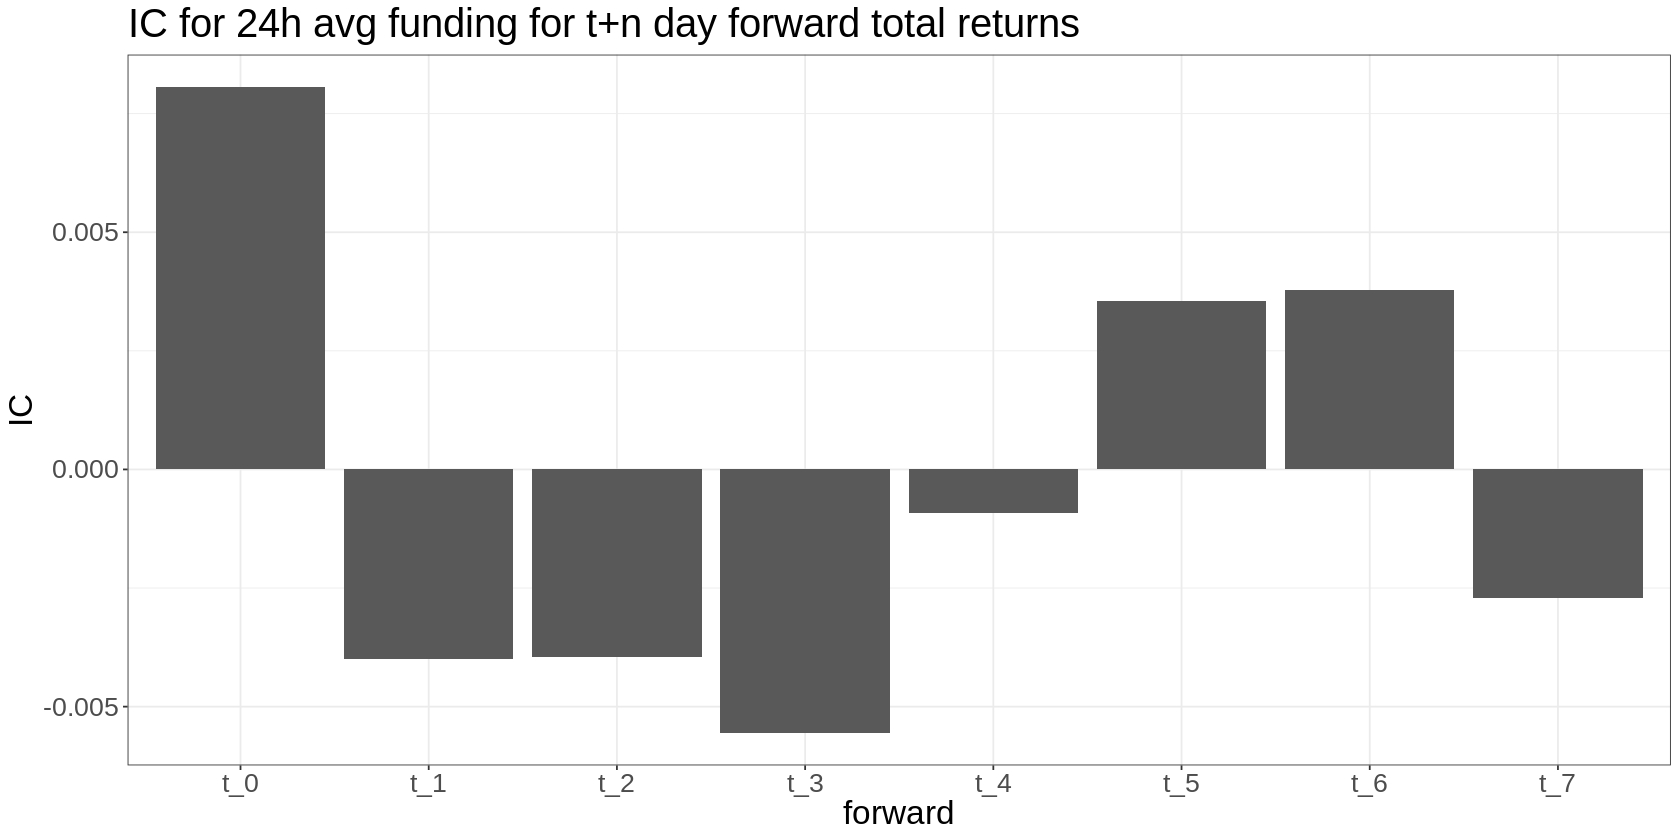

In [14]:
daily_funding %>%
  group_by(ticker) %>%
  arrange(ticker, date) %>%
  mutate(
    t_0 = price_change + funding_accrual,
    t_1 = lead(price_change + funding_accrual, 1),
    t_2 = lead(price_change + funding_accrual, 2),
    t_3 = lead(price_change + funding_accrual, 3),
    t_4 = lead(price_change + funding_accrual, 4),
    t_5 = lead(price_change + funding_accrual, 5),
    t_6 = lead(price_change + funding_accrual, 6),
    t_7 = lead(price_change + funding_accrual, 7)
  ) %>%
  na.omit() %>% 
  pivot_longer(starts_with('t_'), names_to = 'forward', values_to = 'total_returns') %>%
  group_by(forward) %>%
  summarize(IC = cor(lag_funding_accrual, total_returns)) %>% 
  ggplot(aes(x=forward, y = IC)) + geom_bar(stat='identity') +
  ggtitle('IC for 24h avg funding for t+n day forward total returns')

We see very quick decay (on this timescale.)

If we're working with daily data with daily average, we'd want to be rebalancing at least every 24hs - which makes perfect sense.

We need to start looking at different timescales... but first, let's apply normalization.

First let's rank x-sectionally by date, into 10 buckets.

In [15]:
daily_funding %>% 
  group_by(date) %>%
  mutate(decile = ntile(lag_funding_accrual, 10)) %>%
  ungroup() %>%
  summarise(IC = cor(decile, price_change + funding_accrual))


IC
<dbl>
0.02101066


This is slightly lower.

Now, our daily frequency is becoming a limit to analysis. So let's look at higher frequency data.

Now i've got the impression that this signal is stronger "in the tails". 

So let's look at that. Let's sort by the absolute value of carry and plot the information coefficient.

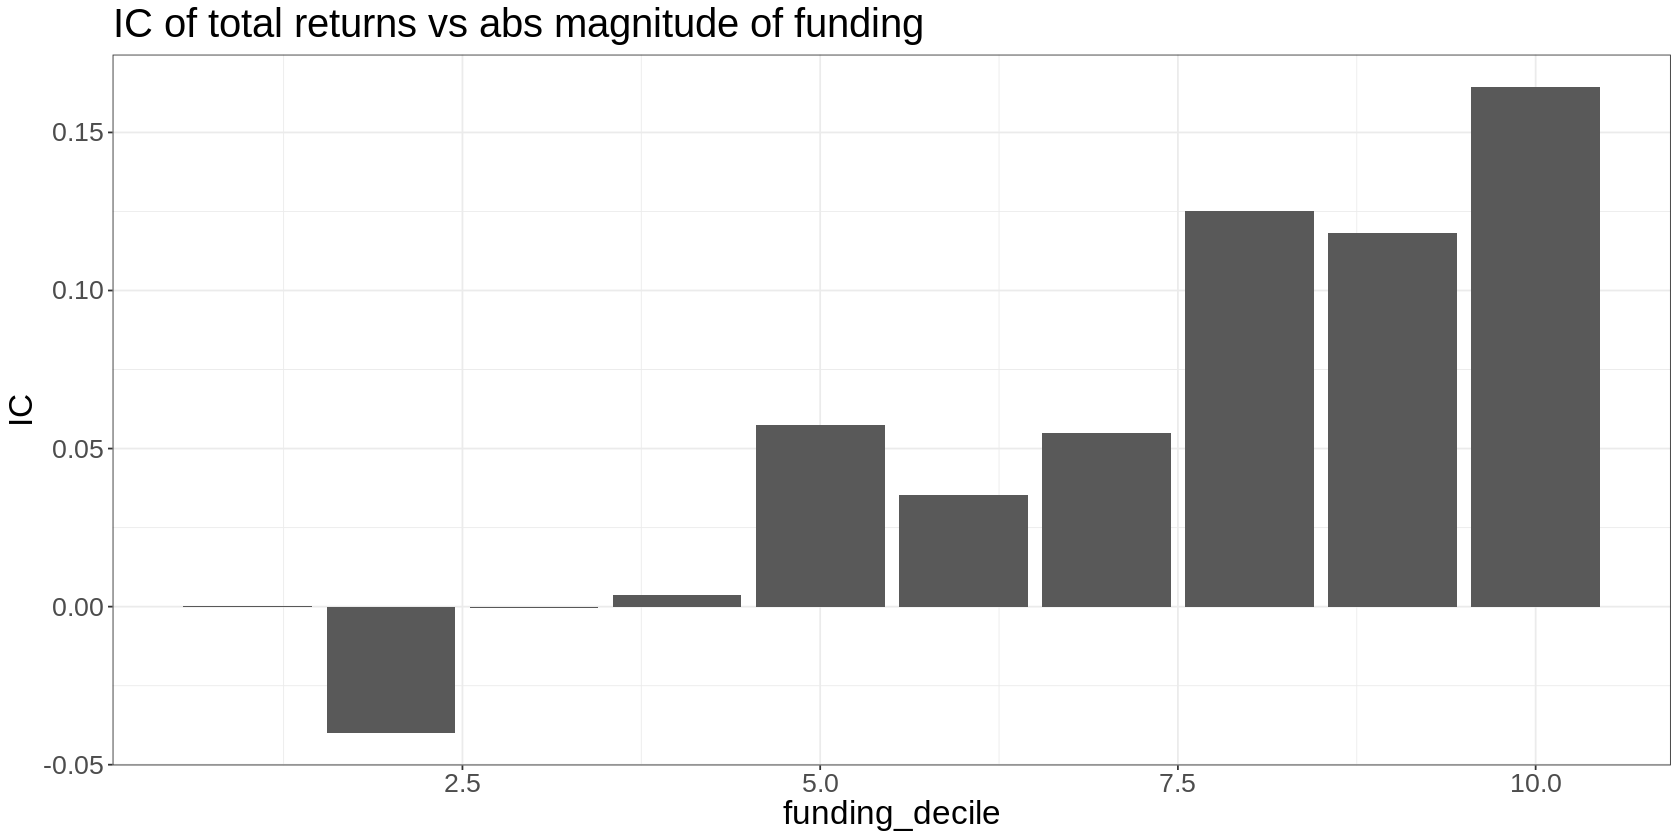

In [16]:
daily_funding %>% 
  group_by(date) %>%
  mutate(funding_decile = ntile(abs(lag_funding_accrual), 10)) %>%
  group_by(funding_decile) %>%
  summarise(IC = cor(lag_funding_accrual, price_change + funding_accrual)) %>%
  ggplot(aes(x=funding_decile, y=IC)) + 
    geom_bar(stat='identity') +
    ggtitle('IC of total returns vs abs magnitude of funding')


This is interesting... 

We see carry only really explain total returns when it's extreme.

Let's look at the components separately.

First, funding rate:

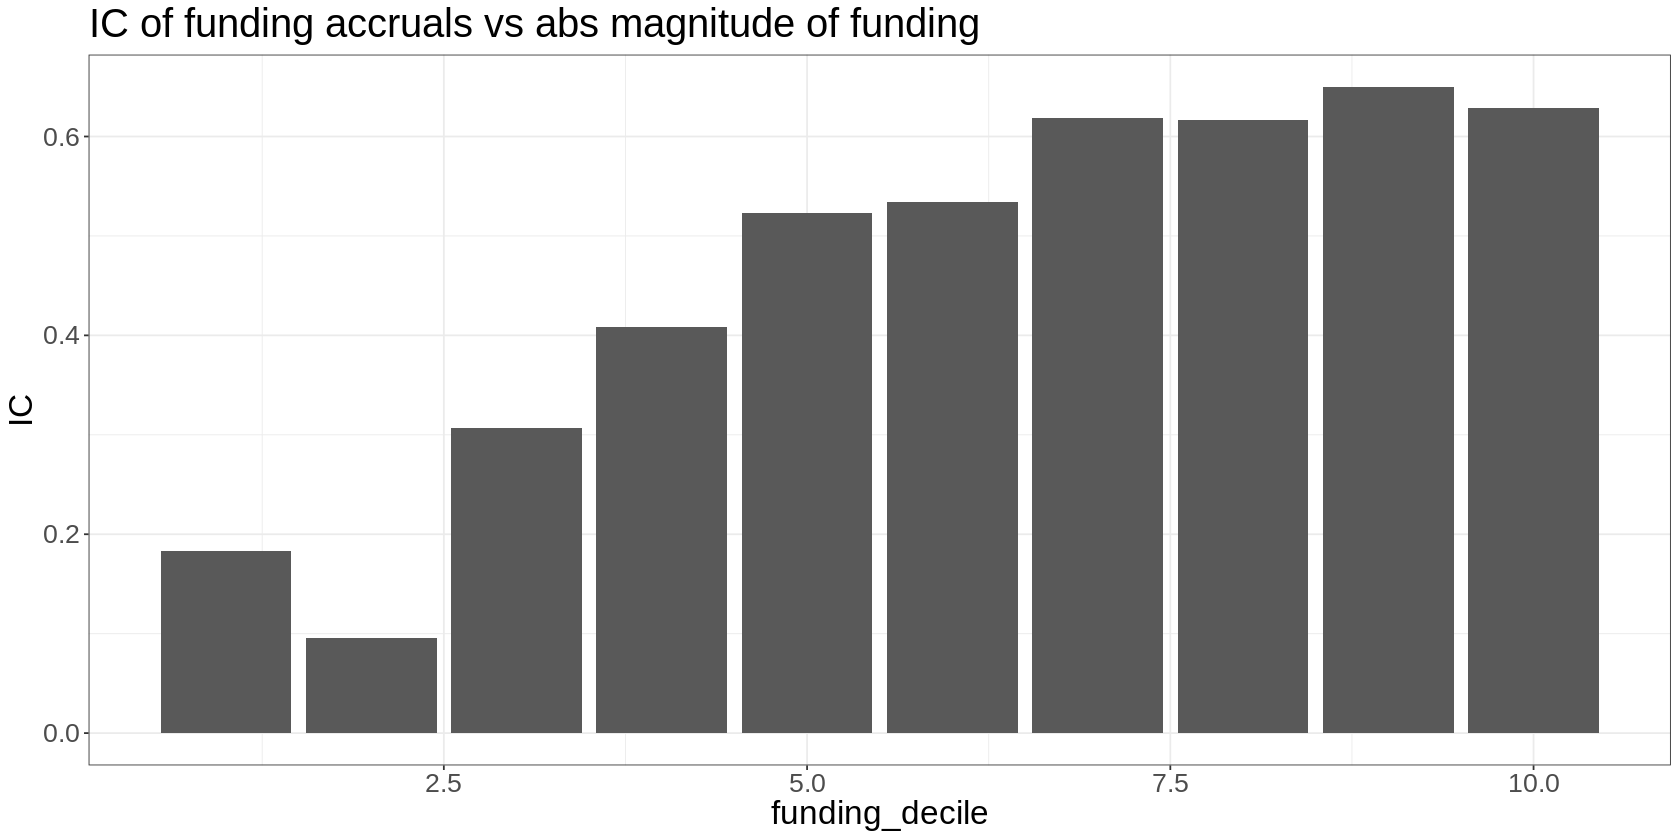

In [17]:
daily_funding %>% 
  group_by(date) %>%
  mutate(funding_decile = ntile(abs(lag_funding_accrual), 10)) %>%
  group_by(funding_decile) %>%
  summarise(IC = cor(lag_funding_accrual, funding_accrual)) %>%
  ggplot(aes(x=funding_decile, y=IC)) +
    geom_bar(stat='identity') + 
    ggtitle('IC of funding accruals vs abs magnitude of funding')

Next price change. We expect to see the CIP type effect... we expect a negative coefficient here.

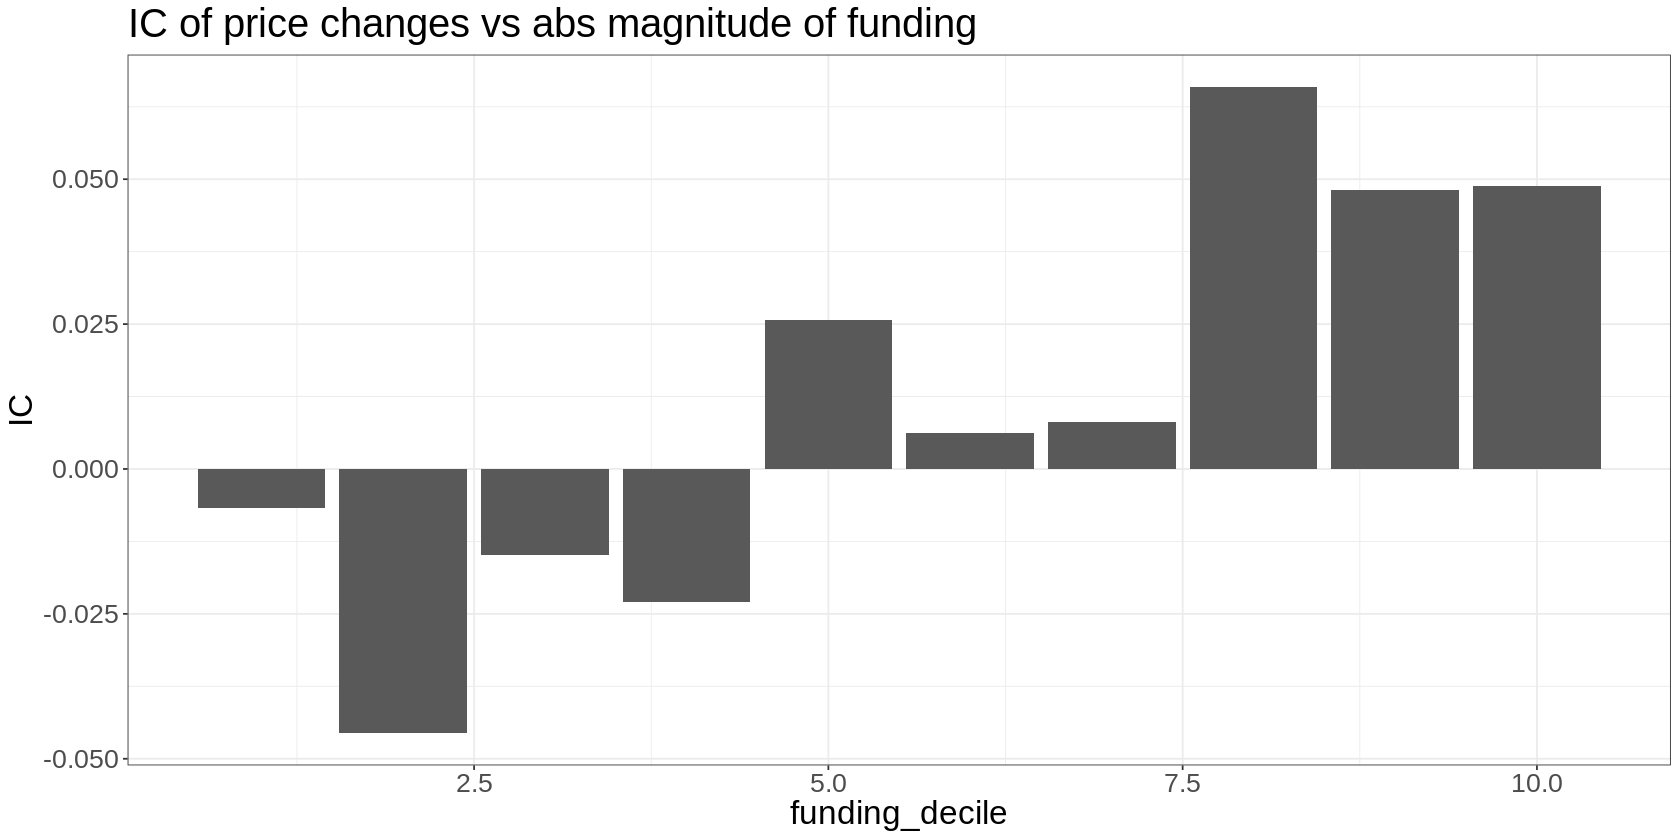

In [18]:
daily_funding %>% 
  group_by(date) %>%
  mutate(funding_decile = ntile(abs(lag_funding_accrual), 10)) %>%
  group_by(funding_decile) %>%
  summarise(IC = cor(lag_funding_accrual, price_change)) %>%
  ggplot(aes(x=funding_decile, y=IC)) + 
    geom_bar(stat='identity') +
    ggtitle('IC of price changes vs abs magnitude of funding') 

So we have interesting observed effect here... where our carry effect appears to exist in extreme cases.

This makes sense because that's where shenanigans (manipulation) and squeeze type behaviour is likely to be found. 

# Now look at hourly resolution

In [19]:
# function for calculating the ewma of a vector v0.1
ewma <- function(x, lambda) {
  ewma = vector(mode = "double", length = length(x))
  ewma[1] = x[1]
  for(i in 2:length(x)) {
    ewma[i]  = (1 - lambda)*x[i] + lambda*ewma[i-1]
  }
  ewma
}

get_lambda_from_half_life <- function(halflife) {
  return(0.5^(1/halflife))
}

In [20]:
hourly_funding <- funding_data %>%
  group_by(ticker) %>%
  mutate(
    price_change = log(close / lag(close)),
    funding_accrual = log(funding_accrual + 1),
    lag_funding = -rate
  ) %>%
  na.omit() %>%
  mutate(
    funding_ema = ewma(lag_funding, 0.9),
    funding_sma = roll_mean(lag_funding, 24)
  ) %>%
  na.omit()

hourly_funding %>% head()

ticker,date,open,high,low,close,volume,rate,price_change,funding_accrual,lag_funding,funding_ema,funding_sma
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALGO-PERP,2019-07-21 13:00:00,0.701,0.7017,0.6951,0.6952,0.000,1.6e-05,-0.0083083131,-3.600065e-05,-1.6e-05,-1.324850e-06,-1.583333e-06
ALT-PERP,2019-07-21 13:00:00,770.300,770.3000,760.6000,765.9000,0.000,-1.0e-05,-0.0057284364,-3.900076e-05,1.0e-05,-8.755652e-06,2.208333e-06
BCH-PERP,2019-07-21 13:00:00,323.950,323.9500,320.4500,321.8500,0.000,-6.3e-05,-0.0065035844,3.899924e-05,6.3e-05,4.866274e-05,4.483333e-05
BNB-PERP,2019-07-21 13:00:00,30.070,30.1100,29.6950,30.0475,2888.451,2.2e-05,-0.0007485342,-2.400029e-05,-2.2e-05,-1.624617e-05,-1.829167e-05
BSV-PERP,2019-07-21 13:00:00,177.040,177.4100,173.8500,174.0500,9343.559,2.4e-05,-0.0170330815,5.999982e-06,-2.4e-05,3.429174e-06,4.583333e-07
BTC-PERP,2019-07-21 13:00:00,10564.000,10592.7500,10488.2500,10542.5000,168375.790,-1.3e-05,-0.0020372878,2.999995e-06,1.3e-05,6.614291e-06,3.750000e-07


In [21]:
hourly_funding %>%
  ungroup() %>%
  summarise(IC = cor(funding_ema, price_change + funding_accrual))

IC
<dbl>
0.036936


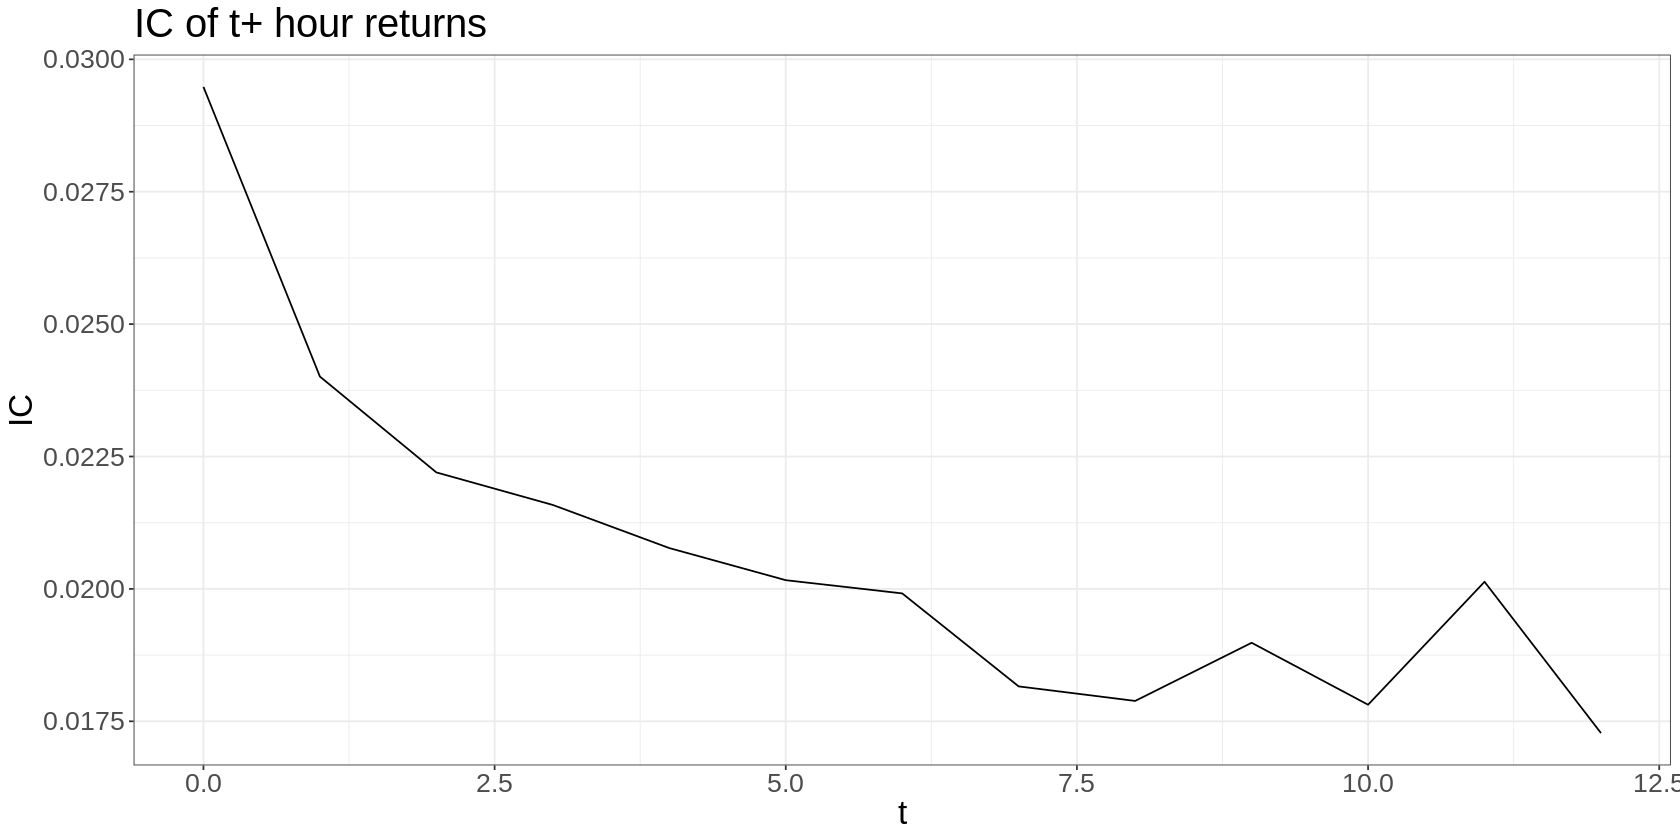

In [22]:
hourly_funding %>%
  group_by(ticker) %>%
  arrange(ticker, date) %>%
  mutate(
    t_0 = price_change + funding_accrual,
    t_1 = lead(price_change + funding_accrual, 1),
    t_2 = lead(price_change + funding_accrual, 2),
    t_3 = lead(price_change + funding_accrual, 3),
    t_4 = lead(price_change + funding_accrual, 4),
    t_5 = lead(price_change + funding_accrual, 5),
    t_6 = lead(price_change + funding_accrual, 6),
    t_7 = lead(price_change + funding_accrual, 7),
    t_8 = lead(price_change + funding_accrual, 8),
    t_9 = lead(price_change + funding_accrual, 9),
    t_10 = lead(price_change + funding_accrual, 10),
    t_11 = lead(price_change + funding_accrual, 11),
    t_12 = lead(price_change + funding_accrual, 12)
  ) %>%
  na.omit() %>% 
  pivot_longer(starts_with('t_'), names_to = 'forward', values_to = 'total_returns') %>%
  group_by(forward) %>%
  mutate(t = as.numeric(substr(forward, 3, length(forward)))) %>%
  summarize(IC = cor(funding_ema, total_returns)) %>%
 mutate(t = as.numeric(substr(forward, 3, length(forward)))) %>%
  ggplot(aes(x=t, y=IC)) + geom_line() + ggtitle('IC of t+ hour returns')

# What next is to do?

Dive into the best foreacast of total returns from carry.

- Should we only be looking at the extremes?
- Is it worth modelling the middle?
- What smoothing?
- Should we account for very short reversion effects?